<a href="https://colab.research.google.com/github/ElenaShargina/nnetworks/blob/main/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B0_ADAM_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BD%D1%8B%D0%B9_%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D0%BD%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Реализована работа алгоритма ADAM на примере трёхслойной нейронной сети.

Функция активация - сигмоидальная.
Корректировка весов происходит с помощью стохастического градиентного спуска (модификация ADAM).



# Подготовка данных

In [26]:
# Импортируем необходимые пакеты
import numpy as np
import matplotlib.pyplot as plt
# Зафиксируем генератор случайных чисел
from numpy.random import seed
seed(2020)

In [27]:
# количество нейронов на входном слое
n_in = 3
# количество нейронов на скрытом слое
n_deep = 3
# величина шага
step = 0.7
# количество эпох без улучшения точности, после которого остановим поиск
patience = 10
# желаемая точность функции ошибки
eps_error = 0.06

# обучающая выборка
dataX = np.array([
    [0.1, 0.2, 0.3, 0.4],
    [0.2, 0.3, 0.4, 0.5],
    [0.3, 0.4, 0.5, 0.6],
    [0.4, 0.5, 0.6, 0.7],
    [0.5, 0.6, 0.7, 0.8],
    [0.6, 0.7, 0.8, 0.9],
    [0.7, 0.8, 0.9, 0],
    [0.8, 0.9, 0, -0.1],
    [0.9, 0, -0.1, -0.2],
    [0, -0.1, -0.2, -0.3],
    [-0.1, -0.2, -0.3, -0.4],
    [-0.2, -0.3, -0.4, -0.5],
    [-0.3, -0.4, -0.5, -0.6],
    [-0.4, -0.5, -0.6, -0.7],
    [-0.5, -0.6, -0.7, -0.8],
    [-0.6, -0.7, -0.8, -0.9],
    [-0.7, -0.8, -0.9, 0]
])
# правильные ответы к обучающей выборке
dataY = np.array([1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 0, -1, -1.2, -1.3, -1.4, -1.5, -1.6, -1.7])


В сети будет три слоя:

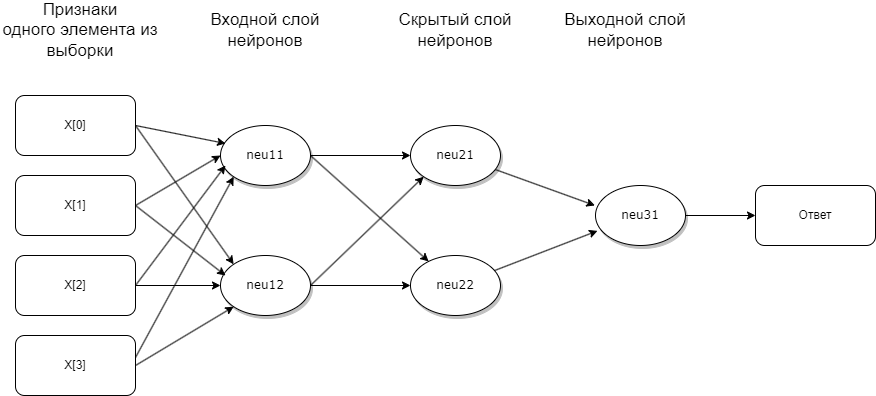

# Объектная модель сети

## Класс нейрона

In [28]:
class Neuron:
    """
    Класс, описывающий нейрон сети. Нейрон хранит в себе веса, инерцию и масштабирование.
    """

    def __init__(self, weights: np.ndarray, v: float = 0.01, g: float = 0.02):
        """
        :param weights: вектор весов, по размеру совпадающий с входами нейрона (количеством признаков в обучающей выборке или количеством нейронов на предыдущем слое)
        :param v: инерция
        :param g: масштабирование
        """
        self.weights = weights
        self.v = v
        self.g = g
        self.dew = np.zeros_like(self.weights)

    def activate(self, x: np.ndarray) -> float:
        """
        вводит в нейрон данные x (из предыдущего нейрона или обучающей выборки),
        перемножает их на соответствующие веса и применяет функцию активации, заданную
        на уровне сети
        :param x: вектор данных, по размеру совпадающий с количеством весов нейрона
        :return: число
        """
        return Net.activate_function(np.sum(self.weights * x))

    def diff_activate(self, x: np.ndarray) -> float:
        """
        вводит в нейрон данные x (из предыдущего нейрона или обучающей выборки),
        перемножает их на соответствующие веса и применяет производную от
        функции активации, заданную на уровне сети
        :param x: вектор данных, по размеру совпадающий с количеством весов нейрона
        :return: число
        """
        return Net.diff_activate_function(np.sum(self.weights * x))

    def sum(self, x: np.ndarray) -> float:
        """
        вводит в нейрон данные x (из предыдущего нейрона или обучающей выборки),
        перемножает их на соответствующие веса и возвращает сумму произведений. Функция
        применяется в нейронах выходного слоя.
        :param x: вектор данных, по размеру совпадающий с количеством весов нейрона
        :return: число
        """
        return np.sum(self.weights * x)

    def correct_v(self, t: int) -> None:
        """
        изменяет инерцию нейрона в зависимости от шага алгоритма
        по формуле, заданной на уровне сети
        :param t: шаг алгоритма
        """
        self.v = Net.correct_v(self.v, self.dew, t)

    def correct_g(self, t: int) -> None:
        """
        изменяет коэффициент масштабирования нейрона в зависимости от шага алгоритма
        по формуле, заданной на уровне сети
        :param t: шаг алгоритма
        """
        self.g = Net.correct_g(self.g, self.dew, t)

    def correct_weights(self, h: float, eps: float) -> None:
        """
        изменяет веса нейрона в зависимости от заданных шага и точности
        по формуле, заданной на уровне сети
        :param h: шаг изменения
        :param eps: точность
        """
        self.weights = Net.correct_weights(self.weights, h, self.v, self.g, eps)


## Классы слоев

In [29]:
class Dense:
    """
    класс, описывающий слой сети. Слой хранит в себе список нейронов, его составляющий.
    """

    def __init__(self):
        self.neurons = []

    def add_neuron(self, n: Neuron) -> None:
        """
        добавляет нейрон внутрь слоя
        :param n: Neuron
        """
        self.neurons.append(n)

    def answer(self, x: np.ndarray) -> np.ndarray:
        """
        генерирует вектор ответов нейронов на введенные данные (обучающую выборку или
        результаты нейронов предыдущего слоя)
        :param x: вектор данных, по размеру совпадающий с количеством весов нейронов этого слоя
        :return: вектор ответов, размер равен числу нейронов этого слоя
        """
        return np.array([n.activate(x) for n in self.neurons])

    @property
    def weights(self) -> np.ndarray:
        """
        Возвращает массив весов нейронов этого слоя размера (кол-во нейронов, число весов одного нейрона)
        :return: массив весов нейронов
        """
        return np.array([n.weights for n in self.neurons])

    def __len__(self) -> int:
        """
        Возвращает количество нейронов в слое.
        """
        return len(self.neurons)

    def __getitem__(self, item: int) -> Neuron:
        """
        Возвращает нейрон по данному индексу.
        :param item: индекс нейрона.
        :return: нейрон по данному индексу.
        """
        return self.neurons[item]


class DenseIn(Dense):
    """
    Подкласс, описывающий входной слой.
    """
    type = 'in'


class DenseDeep(Dense):
    """
    Подкласс, описывающий скрытый слой.
    """
    type = 'deep'


class DenseOut(Dense):
    """
    Подкласс, описывающий выходной слой. Ответ выходного слоя формируется отлично от других слоев,
    с помощью простого суммирования произведений весов нейронов на входные данные.
    """
    type = 'out'

    def answer(self, x):
        return [n.sum(x) for n in self.neurons][0]

## Класс сети

In [30]:
class Net:
    """
    Класс, описывающий сеть.
    Хранит в себе список из трёх слоёв и коэффициенты изменения инерции и масштабирования.
    В нём задаются:
    функция активации нейрона и ее производная,
    функции коррекции инерции, масштабирования и весов нейрона,
    функция вычисления ошибки.
    """
    gammag = 0.2
    gammav = 0.2

    def __init__(self, dense_in: DenseIn, dense_deep: DenseDeep, dense_out: DenseOut):
        self.dense_in = dense_in
        self.dense_deep = dense_deep
        self.dense_out = dense_out

    @staticmethod
    def activate_function(x: float) -> float:
        """
        функция активации нейрона - гиперболический тангенс.
        """
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def diff_activate_function(y: float) -> float:
        """
        производная от функции активации нейрона.
        """
        return np.exp(y) / (1 + np.exp(y)) / (1 + np.exp(y))

    @staticmethod
    def correct_v(v: float, diffe: float, t: int) -> float:
        """
        Функция для коррекции инерции.
        :param v: прежнее значение инерции.
        :param diffe: производная по данному весу данного нейрона.
        :param t: шаг алгоритма
        """
        return (Net.gammav * v + (1 - Net.gammav) * diffe) / (1 - Net.gammav ** t)

    @staticmethod
    def correct_g(g: float, diffe: float, t: float) -> float:
        """
        Функция для коррекции коэффициента масштабирования.
        :param g: прежний коэффициент.
        :param diffe: производная по данному весу данного нейрона.
        :param t: шаг алгоритма
        """
        return (Net.gammag * g + (1 - Net.gammag) * diffe ** 2) / (1 - Net.gammag ** t)

    @staticmethod
    def correct_weights(w: float, h: float, v: float, g: float, eps: float) -> float:
        """
        Функция для коррекции веса нейрона.
        :param w: прежний вес.
        :param h: заданный шаг изменения весов (задается на уровне модели).
        :param v: инерция нейрона.
        :param g: коэффициент масштабирования нейрона.
        :param eps: точность (задается на уровне модели)
        :return:
        """
        return w + h * v / np.sqrt(g + eps)

    def answer(self, x: np.ndarray) -> float:
        """
        генерирует ответ сети на входные значения, прогоняя их через все три слоя
        :param x: вектор входных значений
        """
        dense_in_result = self.dense_in.answer(x)
        dense_deep_result = self.dense_deep.answer(dense_in_result)
        dense_out_result = self.dense_out.answer(dense_deep_result)
        return dense_out_result

    def loss_func(self, dataY: np.ndarray, dataX: np.ndarray) -> float:
        """
        Подсчитывает функцию ошибки на обучающей выборке (dataX) в текущем состоянии сети.
        :param dataY: вектор правильных ответов.
        :param dataX: входные данные - массив признаков
        """
        e = sum([(dataY[i] - self.answer(dataX[i])) ** 2 for i in range(len(dataY))]) / len(dataY)
        return e

    def show(self):
        """
        Выводит информацию о текущем состоянии сети.
        """
        for d in [self.dense_in, self.dense_deep, self.dense_out]:
            print('Dense', d.type)
            for i, n in enumerate(d.neurons):
                print(f'Neuron {i}. weights: {np.round(n.weights, 6)} v: {np.round(n.v, 6)} g: {np.round(n.g, 6)}')


## Класс модели

In [31]:
class Model:
    """
    Класс модели нейронной сети.
    Содержит в себе объект класса Net, который обучает с помощью входной выборки данных.
    """

    def __init__(self, dense_in: int, dense_deep: int, dataX: np.ndarray, dataY: np.ndarray):
        """
        Инициализирует новый объект класса Model.
        Создает объект класса Net по заданным параметрам и начальными значениями весов.
        :param dense_in: количество нейронов на входном слое.
        :param dense_deep: количество нейронов в скрытом слое.
        :param dataX: входная выборка данных
        :param dataY: вектор правильных ответов к входной выборке.
        """
        self.dataX = dataX
        self.dataY = dataY

        def create_dense_weights(x: int, n1: int, n2: int, n3: int) -> list:
            """
            Создает массив с начальными маленькики значениями весов.
            :param x: количество признаков во входной выборке
            :param n1: число нейронов в входном слое
            :param n2: число нейронов в скрытом слое
            :param n3: число нейронов в выходном слое
            :return: список из трех массивов для трех слоев соответственно
            """
            w1 = n1 * x
            w2 = n2 * n1
            w3 = n3 * n2
            w = sum([w1, w2, w3])
            print('w1', w1, 'w2', w2, 'w3', w3)
            step = 1.9 / w
            weights = np.array([round(-0.9 + i * step, 3) for i in range(0, w)])
            return [weights[0:w1].reshape((n1, x)), weights[w1:w1 + w2].reshape((n2, n1)),
                    weights[w1 + w2:].reshape((n3, n2))]

        # строим сеть заданного размера
        # (входной слой - dense_in нейронов, скрытый - dense_deep нейронов, выходной - 1 нейрон)
        weights = create_dense_weights(len(self.dataX[0]), dense_in, dense_deep, 1)

        d1 = DenseIn()
        for w in weights[0]:
            d1.add_neuron(Neuron(w))

        d2 = DenseDeep()
        for w in weights[1]:
            d2.add_neuron(Neuron(w))

        d3 = DenseOut()
        for w in weights[2]:
            d3.add_neuron(Neuron(w))

        # добавляем три слоя в сеть
        self.net = Net(d1, d2, d3)
        self.net.show()

    def __getattr__(self, item: str) -> Dense:
        """
        Служебный метод для упрощения кода
        """
        if item == "dense_in":
                return self.net.dense_in
        elif item == "dense_deep":
                return self.net.dense_deep
        elif item == "dense_out":
                return self.net.dense_out
        else:
                raise AttributeError(f'Attribute {item} in Net is not found')

    def work(self, step: float, eps_error: float, patience: int, iterations: int, eps: float = 0.000001) -> None:
        """
        Проводит обучение сети с заданными параметрами.
        :param step: шаг изменения весов
        :param eps_error: погрешность оценки функции ошибки
        :param patience: сколько итераций продолжать обучение без улучшений
        :param iterations: количество итераций
        :param eps: точность измерений
        """
        # счетчик итераций без улучшений,
        # заканчиваем цикл, если он достигнет параметра patience
        failure_stop = 0
        # список с порядком просмотра входной выборки, будет перемешиваться каждый раз
        index = np.arange(len(self.dataX))
        # счетчик шагов алгоритма
        t = 0
        # Список для запоминания значений функции ошибки
        self.error = list()
        error_old = 0
        for k in range(iterations):
            # перемешиваем порядок просмотра выборки
            np.random.shuffle(index)
            # если идет не первая итерация, то запоминаем предыдущее значение функции ошибки
            if k > 0:
                error_old = error_new

            for i in index:
                # прогоняем входные данные через сеть, фиксируя ответ каждого слоя.
                # Это понадобится для вычисления градиента позже.
                d1 = self.dense_in.answer(self.dataX[i])
                d2 = self.dense_deep.answer(d1)
                d3 = self.dense_out.answer(d2)

                # Посчитаем значение градиента функции потерь, используя обратное распространение ошибки.

                # Рассчитаем ошибку ответа сети
                delta = self.dataY[i] - d3

                # Производные для весов нейронов выходного слоя
                for n, neuron in enumerate(self.dense_out.neurons):
                    for w, weight in enumerate(self.dense_deep):
                        neuron.dew[w] = 2 * delta * d2[w]

                # Производные для весов нейронов скрытого слоя
                for n, neuron in enumerate(self.dense_deep.neurons):
                    for w, weight in enumerate(self.dense_in.neurons):
                        neuron.dew[w] = 2 * delta * self.dense_out[0].weights[n] * neuron.diff_activate(d1) * d1[w]

                # Производные для весов нейронов входного слоя
                for n, neuron in enumerate(self.dense_in.neurons):
                    for w, weight in enumerate(dataX[i]):
                        neuron.dew[w] = 2 * delta * (
                            np.sum([self.dense_out[0].weights[j] * self.dense_deep[j].diff_activate(d1) *
                                    self.dense_deep[j].weights[n] for j in range(len(self.dense_deep))])
                        ) * neuron.diff_activate(self.dataX[i]) * self.dataX[i][w]

                # Корректируем инерцию, масштабирование, веса для каждого нейрона
                for d in [self.dense_in, self.dense_deep, self.dense_out]:
                    for n in d.neurons:
                        n.correct_v(t + 1)
                        n.correct_g(t + 1)
                        n.correct_weights(step, eps)

                # увеличиваем счетчик шагов алгоритма
                t += 1

            # Вычисляем новое значение функции ошибки
            error_new = self.net.loss_func(self.dataY, self.dataX)
            self.error.append(error_new)

            # Если итерация не первая, то проверяем, достаточно ли изменилась ошибка
            if k > 0 and abs(error_new - error_old) < eps:
                failure_stop += 1
            else:
                failure_stop = 0

            if error_new < eps_error:
                print(k + 1, '-я итерация. E = ',
                      round(error_new, 6))
                break

            if failure_stop == patience:
                break
            else:
                print(k + 1, 'я итерация. E = ',
                      round(error_new, 6))

        print(f'Алгоритм проработал {k + 1} итераций.')
        print('Значение функции ошибки: E = ', error_new)
        self.net.show()

    def show_error(self):
        """
        Выводит график изменения функции ошибки в последнее обучение модели.
        """
        plt.plot(self.error)
        plt.xlabel('Итерации алгоритма')
        plt.ylabel('Значение функции ошибки')
        plt.show()

    def show_result(self):
        """
        Выводит наложенные графики правильных ответов и ответов модели с текущими весами нейронов.
        """
        model_answers = np.array([self.net.answer(self.dataX[i]) for i in range(self.dataY.size)])
        plt.plot(model_answers, label='Ответы сети на обучающей выборке')
        plt.plot(dataY, label='Правильные ответы')
        plt.xlabel('Номер элемента в выборке')
        plt.ylabel('Значение ответа')
        plt.legend()
        plt.show()

# Демонстрация работы модели

In [32]:
# Создаем модель с заданными в начале блокнота количество нейронов и входными данными
myModel = Model(n_in, n_deep, dataX, dataY)
# Запускаем обучение с заданными в начале блокнота параметрами
myModel.work(step=step, eps_error=eps_error, patience=10, iterations=4000)

w1 12 w2 9 w3 3
Dense in
Neuron 0. weights: [-0.9   -0.821 -0.742 -0.663] v: 0.01 g: 0.02
Neuron 1. weights: [-0.583 -0.504 -0.425 -0.346] v: 0.01 g: 0.02
Neuron 2. weights: [-0.267 -0.188 -0.108 -0.029] v: 0.01 g: 0.02
Dense deep
Neuron 0. weights: [0.05  0.129 0.208] v: 0.01 g: 0.02
Neuron 1. weights: [0.287 0.367 0.446] v: 0.01 g: 0.02
Neuron 2. weights: [0.525 0.604 0.683] v: 0.01 g: 0.02
Dense out
Neuron 0. weights: [0.762 0.842 0.921] v: 0.01 g: 0.02
1 я итерация. E =  2.788131
2 я итерация. E =  1.266344
3 я итерация. E =  2.241454
4 я итерация. E =  1.298657
5 я итерация. E =  1.256648
6 я итерация. E =  1.290459
7 я итерация. E =  1.520314
8 я итерация. E =  1.283305
9 я итерация. E =  1.408493
10 я итерация. E =  1.258544
11 я итерация. E =  1.430103
12 я итерация. E =  1.236559
13 я итерация. E =  1.387069
14 я итерация. E =  1.394748
15 я итерация. E =  1.266137
16 я итерация. E =  1.360952
17 я итерация. E =  1.839989
18 я итерация. E =  1.317613
19 я итерация. E =  1.3541

Выводим график изменения функции ошибки

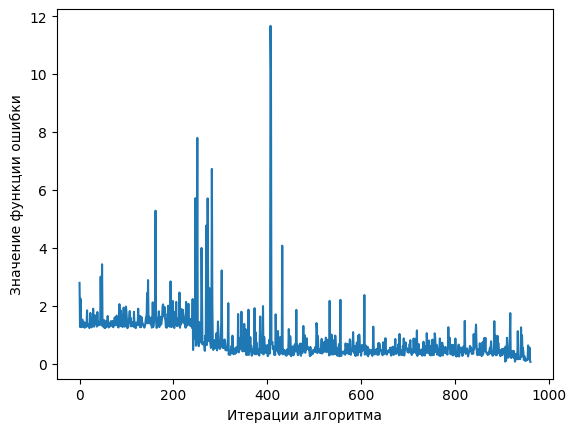

In [33]:
myModel.show_error()

Выводим наложенные графики правильных ответов и ответов модели с текущими весами нейронов.

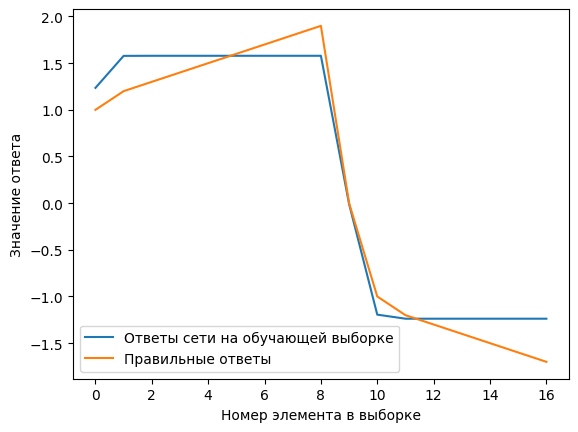

In [34]:
myModel.show_result()

# Функции, использованные в классах нейрона и сети

Функция активации - сигмоидная Net.activate_function(x)

$\phi(x) = \frac{1}{1+e^{-x}}$

Производная от сигмоидной функции - Net.diff_activate_function(x)

$ \phi^\prime(x) = \frac{e^{-x}}{(1+e^{-x})^2}$

Функция потерь (MSE) - Net.loss_func(y,x)

$E(w_1,...,w_n)=\frac{\sum_{i=1}^m{(y-\phi(\sum_{i=1}^n{w_ix_i}))^2}}{m}$

# Работа алгоритма

В методе Net.work() реализован стохастический градиентный спуск - после анализа каждого элемента выборки будем менять веса модели. 
Для этого (на примере сети из 2 нейронов входящего слоя - 2 нейронов скрытого):

 $y$ - правильный ответ

  $y_{i,j}$ - ответ j-того нейрона на i-м слое сети 

  $w_{k,i,j}$ - j-й вес i-того нейрона на k-м слое сети
  
  $x_i$ - признак элемента входящей выборки, стоящий на i-м месте
  1. Посчитаем производные функции ошибки на выходном (3) слое
    
  $\frac{\partial E}{\partial w_{3,i}} = 2(y - y_3)y_{2,i}$

  2. Посчитаем производные функции ошибки на скрытом (2) слое

  $\frac{\partial E}{\partial w_{2,i,j}} = 2(y-y_{3})w_{3,i}\frac{\text{d}\phi(y_2)}{\text{d}w_{2,i}}y_{2,j}$

  3. Посчитаем производные функции ошибки на входном (1) слое

  $\frac{\partial E}{\partial w_{1,i,j}} = 2(y-y_{3})(w_{3,1}\frac{\partial \phi(y_2)}{\partial w_{2,1}}w_{2,1,i}+w_{3,2}\frac{\partial \phi(y_2)}{\partial w_{2,2}}w_{2,2,i})\frac{\partial \phi(x_j)}{\partial w_{1,j}}x_{j}$

  4. Корректируем инерцию для каждого веса

  $\gamma $ - влияние инерции, задано в начале алгоритма (gammav)

  $v_{k,i,j}$ - инерция j-го веса i-го нейрона на k-м слое 

  $E_{k,i,j}$ - производная функции ошибки по j-му весу i-ого нейрона на k-м слое 

  $t$ - итерация алгоритма

  $v\prime_{k,i,j} = \frac{\gamma v_{k,i,j}+( 1-\gamma E_{k,i,j})}{1-\gamma^t}$

  5. Корректируем масштабирование для каждого веса

  $\delta$ - влияение масштабирования, задано в начале алгоритма (gammag)

  $g_{k,i,j}$ - масштабирование j-го веса i-го нейрона на k-м слое

  $g\prime_{k,i,j} = \frac{\delta g_{k,i,j}+(1-\delta)E_{k,i,j}^2}{1-\delta^t}$

  6. Корректируем веса

  $w_{k,i,j}$ - j-й вес i-ого нейрона на k-м слое

  $h$ - шаг алгоритма, задан в начале скрипта  (h)

  $e$ - точность, заданная в начале скрипта (eps)

  $w\prime_{k,i,j} = w_{k,i,j} + h \frac{v_{k,i,j}}{\sqrt{(g_{k,i,j}+eps)}}$

  7. Анализируем функцию ошибки, проверяем, подходит ли она под заданный критерий. Если нет, то начинаем новую итерацию алгоритма. 